In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from collections import OrderedDict, namedtuple
from sqlalchemy import func, distinct, text, and_
import pandas as pd

import util
from util.year import year
from db import session
import model

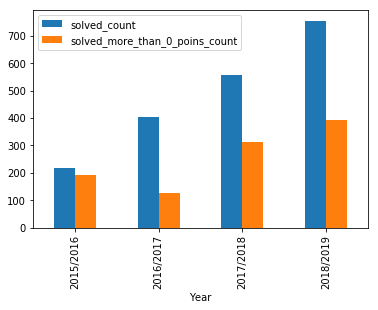

In [33]:
per_module = util.task.points_per_module_all_years().subquery()

per_user = session.query(
    model.Year,
    model.User,
    func.sum(per_module.c.points).label("total_score"),
).\
    join(per_module, model.Year.id == per_module.c.year_id).\
    join(model.User, model.User.id == per_module.c.user_id).\
    filter(model.User.role == 'participant').\
    group_by('year_id', model.User).all()

df = pd.DataFrame(per_user).groupby('Year')
fdf = pd.DataFrame(per_user)
fdf = fdf[fdf['total_score'] > 0].groupby('Year')

per_year = pd.DataFrame(OrderedDict(
    solved_count=df.total_score.count(),
    solved_more_than_0_poins_count=fdf.total_score.count(),
))

per_year.plot.bar()

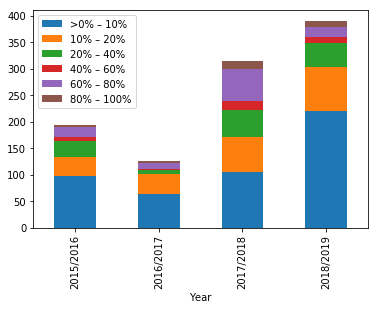

In [34]:
max_points_per_year = util.task.max_points_per_year(bonus=False)

Score = namedtuple('Score', ['Year', 'User', 'RelativePoints'])
relative_per_user = [
    Score(year, user, score / max_points_per_year[year.id][0])
    for year, user, score in per_user
]

fdf = pd.DataFrame(relative_per_user)
fdf = fdf[fdf['RelativePoints'] > 0] # filter 0 points

relative_per_year = pd.DataFrame(OrderedDict((
    ('>0% – 10%', fdf[(fdf['RelativePoints'] >= 0) & (fdf['RelativePoints'] < 0.1)].groupby('Year').RelativePoints.count()),
    ('10% – 20%', fdf[(fdf['RelativePoints'] >= 0.1) & (fdf['RelativePoints'] < 0.2)].groupby('Year').RelativePoints.count()),
    ('20% – 40%', fdf[(fdf['RelativePoints'] >= 0.2) & (fdf['RelativePoints'] < 0.4)].groupby('Year').RelativePoints.count()),
    ('40% – 60%', fdf[(fdf['RelativePoints'] >= 0.4) & (fdf['RelativePoints'] < 0.6)].groupby('Year').RelativePoints.count()),
    ('60% – 80%', fdf[(fdf['RelativePoints'] >= 0.6) & (fdf['RelativePoints'] < 0.8)].groupby('Year').RelativePoints.count()),
    ('80% – 100%', fdf[fdf['RelativePoints'] >= 0.8].groupby('Year').RelativePoints.count()),
)))
relative_per_year.plot.bar(stacked=True)

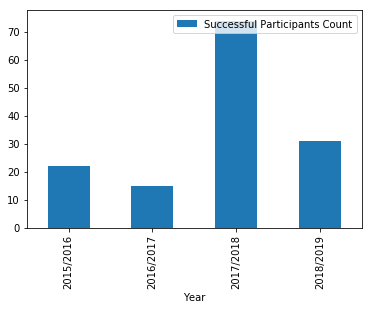

In [42]:
successful_participants = pd.DataFrame({
    'Successful Participants Count': fdf[(fdf['RelativePoints'] >= 0.6)].groupby('Year').RelativePoints.count(),
})
successful_participants.plot.bar(stacked=True)